In [12]:
%load_ext autoreload

In [1]:
import numpy as np
import ipywidgets
from jupyter_ui_poll import ui_events

from libertem.api import Context

from libertem.udf.sum import SumUDF
from libertem.viz.bqp import BQLive2DPlot

from microscope_calibration.udf.stem_overfocus import OverfocusUDF, OverfocusParams
from microscope_calibration.common.stem_overfocus import make_model
from temgymbasic.run import show_matplotlib

In [2]:
# Thx Mat!
def notebook_fullwidth():
    from IPython.display import display, HTML
    """Set notebook display to 95% fullwidth for more available space"""
    display(HTML(data="""
    <style>
        div#notebook-container    { width: 95%; }
        div#menubar-container     { width: 65%; }
        div#maintoolbar-container { width: 99%; }
    </style>
    """))
notebook_fullwidth()

In [3]:
ctx = Context()

In [4]:
ds = ctx.load('auto', path=r'C:\Users\weber\Nextcloud3\ER-C-Data\adhoc\livecalibration\20221025_154811\rotation_calibration.hdr')

In [5]:
overfocus_params = OverfocusParams(
    overfocus=0.001,  # m
    scan_pixel_size=0.000001,  # m
    camera_length=0.15,  # m
    detector_pixel_size=0.000050,  # m
    semiconv=0.020,  # rad
    #'scan_rotation': 37,
    scan_rotation=0.,
    flip_y=False,
    # Offset to avoid subchip gap
    cy=ds.shape.sig[0] / 2 - 2,
    cx=ds.shape.sig[1] / 2 - 2,
)


In [6]:
keep_running = True
def on_click(btn):
    global keep_running
    keep_running = False
    btn.description = '👍 stopping'

stop_btn = ipywidgets.Button(description='Stop series')
stop_btn.on_click(on_click)

In [7]:
test_params = overfocus_params.copy()
test_params['scan_rotation'] = 330

In [8]:
overfocus_udf = OverfocusUDF(
    overfocus_params=test_params.copy(),
)
sum_udf = SumUDF()

point_plot = BQLive2DPlot(dataset=ds, udf=overfocus_udf, channel='point')
shifted_sum_plot = BQLive2DPlot(dataset=ds, udf=overfocus_udf, channel='shifted_sum')
selected_plot = BQLive2DPlot(dataset=ds, udf=overfocus_udf, channel='selected')
sum_plot = BQLive2DPlot(dataset=ds, udf=overfocus_udf, channel='sum')
sum_plot_plain = BQLive2DPlot(dataset=ds, udf=sum_udf, channel='intensity')

plots = (point_plot, shifted_sum_plot, sum_plot_plain, selected_plot, sum_plot)

adjustment_outputs = []

for p in plots:
    # Capture the plots to display them in a grid later
    output = ipywidgets.Output()
    with output:
        p.display()
        # Some plot-specific tweaks for grid display
        if isinstance(p, BQLive2DPlot):
            p.figure.fig_margin={'top': 50, 'bottom': 0, 'left': 25, 'right': 25}
            p.figure.layout.width = '250px'
            p.figure.layout.height = '250px'
    adjustment_outputs.append(output)

rp = test_params
    
scan_rotation = ipywidgets.FloatSlider(min=0, max=360, description='Scan rotation / deg', value=rp['scan_rotation'])
flip_y = ipywidgets.Checkbox(description='Flip detector Y axis', value=rp['flip_y'])
overfocus = ipywidgets.FloatText(description='Overfocus / m', value=rp['overfocus'])
camera_length = ipywidgets.FloatText(description='Camera length / m', value=rp['camera_length'])
detector_pixel_size = ipywidgets.FloatText(description='Detector pixel size / m', value=rp['detector_pixel_size'])
scan_pixel_size = ipywidgets.FloatText(description='Scan pixel size / m', value=rp['scan_pixel_size'])
    
ipywidgets.VBox([
    ipywidgets.HBox(adjustment_outputs[0:3]),
    ipywidgets.HBox(adjustment_outputs[3:5]),
    scan_rotation,
    flip_y,
    ipywidgets.HBox([overfocus, camera_length]),
    ipywidgets.HBox([detector_pixel_size, scan_pixel_size]),
    stop_btn
])

In [78]:
with ui_events() as poll:
    keep_running = True
    stop_btn.description = 'Stop series'
    while keep_running:
        tp = test_params
        tp['scan_rotation'] = scan_rotation.value
        tp['flip_y'] = flip_y.value
        tp['overfocus'] = overfocus.value
        tp['camera_length'] = camera_length.value
        tp['detector_pixel_size'] = detector_pixel_size.value
        tp['scan_pixel_size'] = scan_pixel_size.value
        result_iter = ctx.run_udf_iter(dataset=ds, udf=(overfocus_udf, sum_udf), plots=plots)
        for adjustment_res in result_iter:
            result_iter.update_parameters_experimental([
                {'overfocus_params': tp},
                {}
            ])
            poll(100)
    stop_btn.description = 'Stopped'

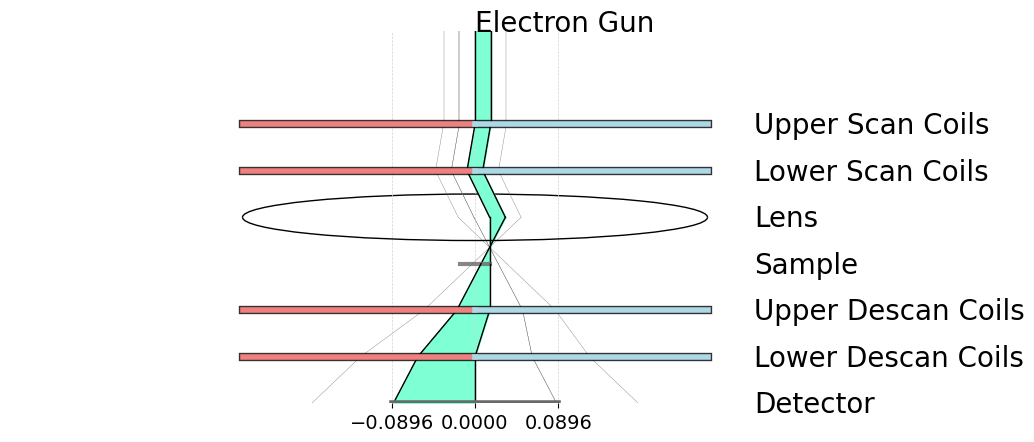

In [77]:
%autoreload
model = make_model(tp, ds.shape)
model.components[model.sample_idx].sample_size *= 500
model.sample.width *= 500  # somehow necessary for graphical display
model.detector_size *= 7
model.semiconv *= 60
model.set_beam_radius_from_semiconv(model.semiconv)
model.overfocus *= 30
model.set_obj_lens_f_from_overfocus(model.overfocus)
model.generate_rays()
model.scan_pixel_y = 0
model.scan_pixel_x = 0
model.update_scan_coil_ratio()
fig, axes = show_matplotlib(model)
fig.savefig('visualization.svg')